In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import numpy as np

In [2]:
import tensorboard as tb
from scipy import stats
import seaborn as sns

In [3]:
tb.__version__

'2.13.0'

In [4]:
from tensorflow.python.summary.summary_iterator import summary_iterator


2024-08-16 17:59:47.866339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 17:59:49.409714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
"""
code modified from this gist on github: https://gist.github.com/laszukdawid/62656cf7b34cac35b325ba21d46ecfcd
blog post here: https://laszukdawid.com/blog/2021/01/26/parsing-tensorboard-data-locally/
"""

def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['exp_step', 'wall_time', 'name', 'step', 'value']
    
    out = []
    for exp_dir in os.listdir(root_dir):
        exp_dir_path = os.path.join(root_dir, exp_dir)
        # print(exp_dir_path)
        # print("all: ", os.listdir(exp_dir_path))
        filenames = list(filter(lambda x: os.path.isfile(os.path.join(exp_dir_path, x)), os.listdir(exp_dir_path)))
        # print("filtered: ", filenames)
        for filename in filenames:
            # print(filename)
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root_dir, exp_dir, filename)
            file_df = convert_tfevent(file_full_path)
            file_df['exp_step'] = exp_dir
            out.append(file_df)
    # print(out)

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)



In [6]:
dir_path = "log/coco/transpose_r_mod/osiris/"
# exp_name = "exp9_step1_scalingBN_2024-07-30-11-22"
exp_name = "exp13"
df = convert_tb_data(f"{dir_path}/{exp_name}")

print(df)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
                                     exp_step     wall_time        name  step  \
0       exp13_step1_finetune_2024-08-15-06-39  1.723704e+09  train_loss     0   
1       exp13_step1_finetune_2024-08-15-06-39  1.723704e+09   train_acc     0   
2       exp13_step1_finetune_2024-08-15-06-39  1.723704e+09  train_loss     1   
3       exp13_step1_finetune_2024-08-15-06-39  1.723704e+09   train_acc     1   
4       exp13_step1_finetune_2024-08-15-06-39  1.723704e+09  train_loss     2   
...                                       ...           ...         ...   ...   
27387  exp13_step8_scalingBN_2024-08-16-11-36  1.723810e+09   train_acc   188   
27388  exp13_step8_scalingBN_2024-08-16-11-36  1.723810e+09  train_loss   189   
27389  exp13_step8_scalingBN_2024-08-16-11-36  1.723810e+09   train_acc   189   
27390  exp13_step8_scalingBN_2024-08-16-11-36  1.723810e+09  valid_loss     9   
27391  exp13_step8_scali

In [7]:
df.to_csv("exp13_results.csv")

In [8]:
exp13_res = pd.read_csv("exp13_results.csv", index_col=0)

In [9]:
exp_var_list = pd.unique(exp13_res['exp_step'])

In [10]:
pd.unique(exp13_res["name"])

array(['train_loss', 'train_acc', 'valid_loss', 'valid_acc'], dtype=object)

In [11]:
exp_var_list

array(['exp13_step1_finetune_2024-08-15-06-39',
       'exp13_step1_scalingBN_2024-08-15-06-08',
       'exp13_step2_finetune_2024-08-15-09-53',
       'exp13_step2_scalingBN_2024-08-15-09-24',
       'exp13_step3_finetune_2024-08-15-13-39',
       'exp13_step3_scalingBN_2024-08-15-13-09',
       'exp13_step4_finetune_2024-08-15-17-06',
       'exp13_step4_scalingBN_2024-08-15-16-38',
       'exp13_step5_finetune_2024-08-15-21-06',
       'exp13_step5_scalingBN_2024-08-15-20-22',
       'exp13_step6_finetune_2024-08-16-00-27',
       'exp13_step6_scalingBN_2024-08-15-23-55',
       'exp13_step7_finetune_2024-08-16-09-03',
       'exp13_step7_scalingBN_2024-08-16-08-33',
       'exp13_step8_finetune_2024-08-16-12-10',
       'exp13_step8_scalingBN_2024-08-16-11-36'], dtype=object)

In [15]:
exp_steps = {
       'exp13_step1_scalingBN_2024-08-15-06-08': 'step 1 scaling',
       'exp13_step1_finetune_2024-08-15-06-39': 'step 1 train',
       'exp13_step2_scalingBN_2024-08-15-09-24': 'step 2 scaling',
        'exp13_step2_finetune_2024-08-15-09-53': 'step 2 train',
       'exp13_step3_scalingBN_2024-08-15-13-09': 'step 3 scaling',
       'exp13_step3_finetune_2024-08-15-13-39': 'step 3 train',
       'exp13_step4_scalingBN_2024-08-15-16-38': 'step 4 scaling',
       'exp13_step4_finetune_2024-08-15-17-06': 'step 4 train',
       'exp13_step5_scalingBN_2024-08-15-20-22': 'step 5 scaling',
       'exp13_step5_finetune_2024-08-15-21-06': 'step 5 train',
       'exp13_step6_scalingBN_2024-08-15-23-55': 'step 6 scaling',
       'exp13_step6_finetune_2024-08-16-00-27': 'step 6 train',
       'exp13_step7_scalingBN_2024-08-16-08-33': 'step 7 scaling',
       'exp13_step7_finetune_2024-08-16-09-03': 'step 7 train',
       'exp13_step8_scalingBN_2024-08-16-11-36': 'step 8 scaling',
       'exp13_step8_finetune_2024-08-16-12-10': 'step 8 train',
       
    
}

step 1 scaling max train acc: 0.9700279831886292
step 1 train max train acc: 0.9532212615013124
step 2 scaling max train acc: 0.9198879599571228
step 2 train max train acc: 0.9523809552192688
step 3 scaling max train acc: 0.9415265917778016
step 3 train max train acc: 0.9714285731315612
step 4 scaling max train acc: 0.9397758841514589
step 4 train max train acc: 0.9539215564727784
step 5 scaling max train acc: 0.9317927360534668
step 5 train max train acc: 0.9341736435890198
step 6 scaling max train acc: 0.8934173583984375
step 6 train max train acc: 0.9464285969734192
step 7 scaling max train acc: 0.9369747638702391
step 7 train max train acc: 0.96875
step 8 scaling max train acc: 0.9156162738800048
step 8 train max train acc: 0.9323529601097108


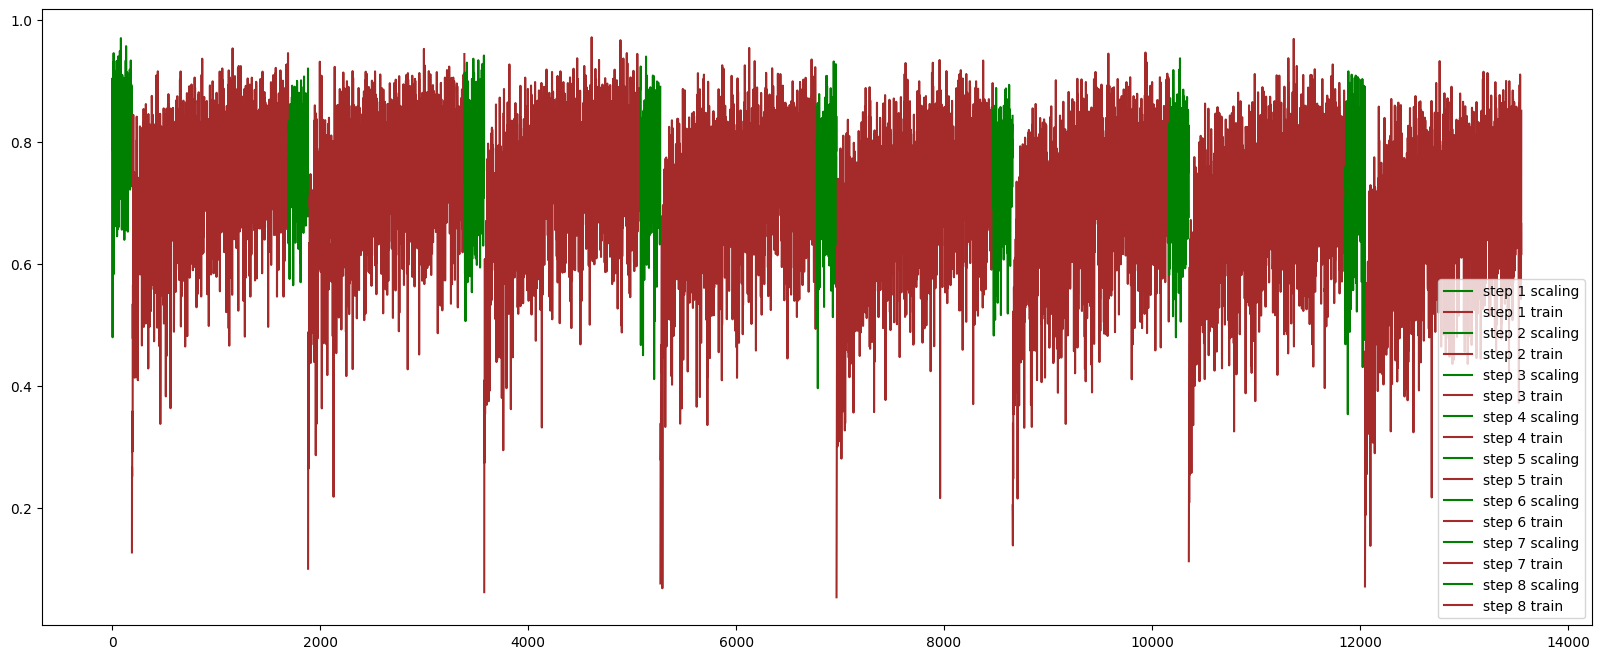

In [16]:
fig, axs = plt.subplots(figsize=(20, 8))
offset = 0


for exp_name, exp_legend in exp_steps.items():
    train_acc = exp13_res[exp13_res.exp_step == exp_name]
    train_acc = train_acc[train_acc.name == "train_acc"]
    print(f"{exp_legend} max train acc: {np.max(train_acc.value)}")
    if 'scalingBN' in exp_name:
        c = 'green'
    else:
        c = 'brown'
    axs.plot(offset + train_acc.step, train_acc.value, label=f"{exp_legend}", color=c)
    # axs.scatter(offset + train_acc.step, train_acc.value, color=c)
    
    offset += len(train_acc)

axs.legend()

step 1 scaling max val acc: 0.8603277802467346
step 1 train max val acc: 0.8389070630073547
step 2 scaling max val acc: 0.8355829119682312
step 2 train max val acc: 0.8334641456604004
step 3 scaling max val acc: 0.8308243751525879
step 3 train max val acc: 0.8264462351799011
step 4 scaling max val acc: 0.8234904408454895
step 4 train max val acc: 0.8201659917831421
step 5 scaling max val acc: 0.8159030079841614
step 5 train max val acc: 0.8114815354347229
step 6 scaling max val acc: 0.810856282711029
step 6 train max val acc: 0.8085048198699951
step 7 scaling max val acc: 0.8035126328468323
step 7 train max val acc: 0.8044043779373169
step 8 scaling max val acc: 0.8008161187171936
step 8 train max val acc: 0.7941253781318665


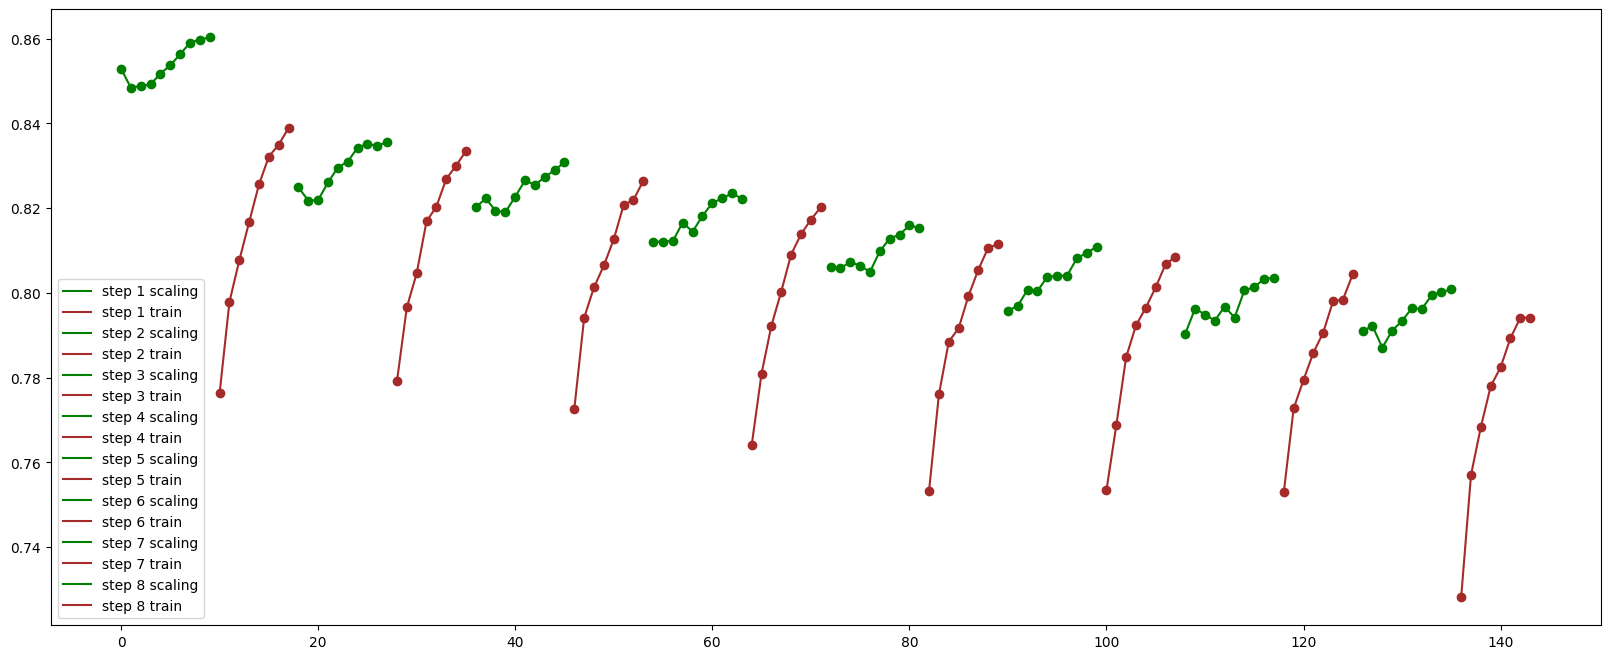

In [17]:
fig, axs = plt.subplots(figsize=(20, 8))
offset = 0


for exp_name, exp_legend in exp_steps.items():
    val_acc = exp13_res[exp13_res.exp_step == exp_name]
    val_acc = val_acc[val_acc.name == "valid_acc"]
    print(f"{exp_legend} max val acc: {np.max(val_acc.value)}")
    if 'scalingBN' in exp_name:
        c = 'green'
    else:
        c = 'brown'
    axs.plot(offset + val_acc.step, val_acc.value, label=f"{exp_legend}", color=c)
    axs.scatter(offset + val_acc.step, val_acc.value, color=c)
    
    offset += len(val_acc)

axs.legend()


In [13]:
exp9_model_size_iter = [4735825, 4560809, 4404541, 4273477, 4152962, 4051729, 3970067]

In [14]:
exp9_sparsity = []
for i in range(len(exp9_model_size_iter)):
    exp9_sparsity.append(1 - exp9_model_size_iter[i] / exp9_model_size_iter[0])

Text(0.5, 1.0, 'Performance vs Sparsity - Experiment 9')

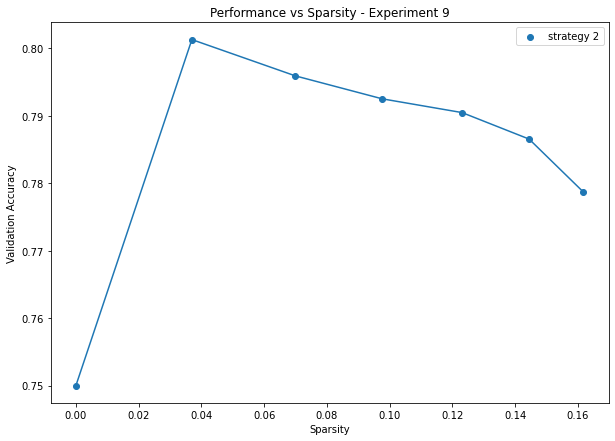

In [17]:
fig, axs = plt.subplots(figsize=(10,7))
# axs.scatter(exp4_sparsity, exp4_model_acc_iter, label="strategy 1")
# axs.plot(exp4_sparsity, exp4_model_acc_iter)
axs.scatter(exp9_sparsity, exp9_val_acc, label="strategy 2")
axs.plot(exp9_sparsity, exp9_val_acc)
axs.legend()
axs.set_ylabel("Validation Accuracy")
axs.set_xlabel("Sparsity")
axs.set_title("Performance vs Sparsity - Experiment 9")

In [18]:
exp11_sparsity, exp11_val_acc = ([0.0,
  0.09235370817122679,
  0.15312369017013927,
  0.19201828614866467,
  0.2186738319089071,
  0.2345523747182381,
  0.24467563729656394],
 [0.75,
  0.7819785475730896,
  0.7684178352355957,
  0.7533857822418213,
  0.7362790703773499,
  0.7265152335166931,
  0.7178179025650024])

Text(0.5, 1.0, 'Performance vs Sparsity - Experiment 9')

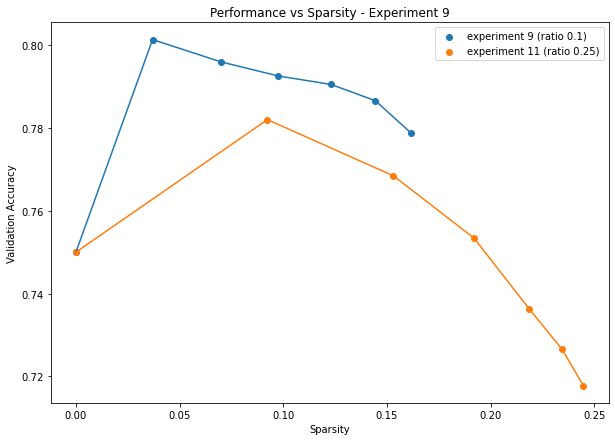

In [19]:
fig, axs = plt.subplots(figsize=(10,7))

axs.scatter(exp9_sparsity, exp9_val_acc, label="experiment 9 (ratio 0.1)")
axs.plot(exp9_sparsity, exp9_val_acc)
axs.scatter(exp11_sparsity, exp11_val_acc, label="experiment 11 (ratio 0.25)")
axs.plot(exp11_sparsity, exp11_val_acc)

axs.legend()
axs.set_ylabel("Validation Accuracy")
axs.set_xlabel("Sparsity")
axs.set_title("Performance vs Sparsity - Experiment 9")

In [20]:
exp4_model_size_iter = [4735825, 4398782, 4158662, 4029203, 3932515, 3874012, 3832886]
exp4_model_acc_iter = [0.75, 0.713819, 0.501036, 0.495939, 0.467798,  0.476604, 0.493471]
exp4_sparsity = []
for i in range(len(exp4_model_size_iter)):
    exp4_sparsity.append(1 - exp4_model_size_iter[i] / exp4_model_size_iter[0])

exp5_model_size_iter = [4735825, 4605918, 4476708, 4376520, 4295517, 4220238, 4147165, 4082626, 4028562, 3987670, 3958666, 3931900,3908419,3888909,3870814,3855166,3840072]
exp5_model_acc_iter = [0.75,
 0.7302373051643372,
 0.5465355515480042,
 0.5546813011169434,
 0.5536966323852539,
 0.5650492906570435,
 0.5708903670310974,
 0.5760945677757263,
 0.5677136182785034,
 0.5634236335754395,
 0.5717630386352539,
 0.5829297304153442,
 0.5836454033851624,
 0.5899275541305542,
 0.5911630392074585,
 0.5920844674110413,
 0.5923865437507629]
exp5_sparsity = []
for i in range(len(exp5_model_size_iter)):
    exp5_sparsity.append(1 - exp5_model_size_iter[i] / exp5_model_size_iter[0])

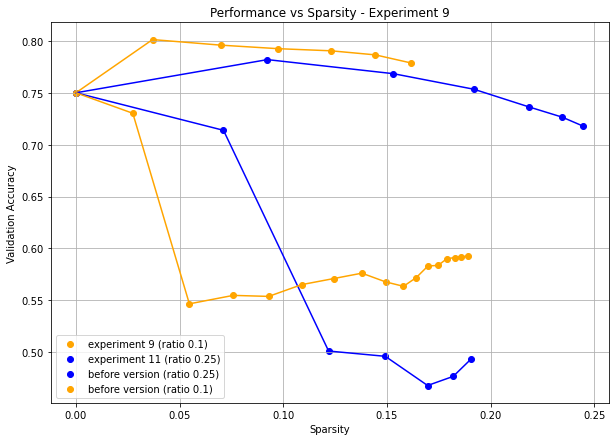

In [25]:
fig, axs = plt.subplots(figsize=(10,7))

axs.scatter(exp9_sparsity, exp9_val_acc, label="experiment 9 (ratio 0.1)", color = "orange")
axs.plot(exp9_sparsity, exp9_val_acc, color = "orange")
axs.scatter(exp11_sparsity, exp11_val_acc, label="experiment 11 (ratio 0.25)", color = 'blue')
axs.plot(exp11_sparsity, exp11_val_acc, color = 'blue')

axs.scatter(exp4_sparsity, exp4_model_acc_iter, label="before version (ratio 0.25)", color = 'blue')
axs.plot(exp4_sparsity, exp4_model_acc_iter, color = 'blue')
axs.scatter(exp5_sparsity, exp5_model_acc_iter, label="before version (ratio 0.1)", color = "orange")
axs.plot(exp5_sparsity, exp5_model_acc_iter, color = "orange")

axs.legend()
axs.set_ylabel("Validation Accuracy")
axs.set_xlabel("Sparsity")
axs.set_title("Performance vs Sparsity - Experiment 9")
axs.grid(True)